In [167]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle

# Torch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

# Data Encoding and Scaling
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, RobustScaler, StandardScaler, FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

# Pipeline
import sklearn
from sklearn.pipeline import Pipeline
from sklearn import set_config

# Clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [179]:
print(f'Pandas Version is {pd.__version__}')
print(f'Numpy Version is {np.__version__}')
print(f'Scikit-Learn Version is {sklearn.__version__}')
print(f'Torch Version is {torch.__version__}')

Pandas Version is 2.2.2
Numpy Version is 1.26.4
Scikit-Learn Version is 1.5.1
Torch Version is 2.6.0+cpu


In [2]:
warnings.filterwarnings('ignore')

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [4]:
df = pd.read_csv('experiment_data1.csv')

In [5]:
df.head()

,jobma_catcher_id,is_premium,subscription_status,company_size,total_sub,is_unlimited,subscription_amount_in_dollars,number_of_subscriptions,number_of_invitations,job_posted,number_of_kits,number_of_recorded_interviews,number_of_live_interviews,days_since_last_login
0,2656,0,0,1-25,1,1,175.994368,1,4,1,2,1,0,More than 1 Year
1,2935,0,1,26-100,0,0,0.623020,1,0,0,0,0,0,More than 1 Year
2,2937,0,1,101-500,0,0,1.384489,1,0,0,0,0,0,More than 1 Year
3,2938,0,0,26-100,0,0,375.008213,3,0,1,0,0,0,More than 1 Year
4,2939,0,1,26-100,0,0,138.448903,1,0,1,0,0,0,More than 1 Year


In [6]:
df.columns

Index(['jobma_catcher_id', 'is_premium', 'subscription_status', 'company_size',
       'total_sub', 'is_unlimited', 'subscription_amount_in_dollars',
       'number_of_subscriptions', 'number_of_invitations', 'job_posted',
       'number_of_kits', 'number_of_recorded_interviews',
       'number_of_live_interviews', 'days_since_last_login'],
      dtype='object')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4461 entries, 0 to 4460
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   jobma_catcher_id                4461 non-null   int64  
 1   is_premium                      4461 non-null   int64  
 2   subscription_status             4461 non-null   int64  
 3   company_size                    4461 non-null   object 
 4   total_sub                       4461 non-null   int64  
 5   is_unlimited                    4461 non-null   int64  
 6   subscription_amount_in_dollars  4461 non-null   float64
 7   number_of_subscriptions         4461 non-null   int64  
 8   number_of_invitations           4461 non-null   int64  
 9   job_posted                      4461 non-null   int64  
 10  number_of_kits                  4461 non-null   int64  
 11  number_of_recorded_interviews   4461 non-null   int64  
 12  number_of_live_interviews       44

# Use this for merging in the end

In [9]:
''' Backup DataFrame '''
backup_df = df.copy()

In [10]:
df.drop('jobma_catcher_id', axis=1, inplace=True)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4461 entries, 0 to 4460
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   is_premium                      4461 non-null   int64  
 1   subscription_status             4461 non-null   int64  
 2   company_size                    4461 non-null   object 
 3   total_sub                       4461 non-null   int64  
 4   is_unlimited                    4461 non-null   int64  
 5   subscription_amount_in_dollars  4461 non-null   float64
 6   number_of_subscriptions         4461 non-null   int64  
 7   number_of_invitations           4461 non-null   int64  
 8   job_posted                      4461 non-null   int64  
 9   number_of_kits                  4461 non-null   int64  
 10  number_of_recorded_interviews   4461 non-null   int64  
 11  number_of_live_interviews       4461 non-null   int64  
 12  days_since_last_login           44

In [12]:
df.dropna(inplace=True)

In [13]:
''' This Function is to fill all missing values (if col is int then 0, if col is float then 0.0 and if col is object then 'Unkmown') '''

def fill_missing_values(df):
    df = df.copy()
    fill_values = {
        'is_premium': 0,
        'subscription_status': 1,
        'company_size': 'More than 1000',
        'total_sub': 0,
        'is_unlimited': 1,
        'subscription_amount_in_dollars': 0,
        'number_of_subscriptions': 0,
        'number_of_invitations': 0,
        'job_posted': 0,
        'number_of_kits': 0,
        'number_of_recorded_interviews': 0,
        'number_of_live_interviews': 0,
        'days_since_last_login': 'More than 1 Year'
    }
    return df.fillna(fill_values)

# Data Encoding

In [15]:
def ordinal_encoder(df):
    # Define the ordinal column and the ordering
    ordinal_col = ['company_size', 'days_since_last_login']
    company_size_order = ['1-25', '26-100', '101-500', '500-1000', 'More than 1000']
    login_days_order = ['Less than 1 Week', '1-4 Weeks', '1-3 Months', '3-6 Months', '6-12 Months', 'More than 1 Year']

    total_order = [company_size_order, login_days_order]
    # Initialize OrdinalEncoder with specified categories
    ordinal = OrdinalEncoder(categories=total_order)
    
    # Fit and transform the data (make sure input is 2D for encoding)
    encoded = ordinal.fit_transform(df[ordinal_col].astype(str))

    # Shifting encoding to start from 1
    encoded += 1
    
    # Convert the encoded result to a DataFrame with the appropriate column name
    encoded_df = pd.DataFrame(encoded, columns=[f'{col}_ord' for col in ordinal_col], index=df.index)

    # Drop the original column
    df.drop(columns=ordinal_col, inplace=True)

    # Concatenate the encoded column to the original dataframe
    df = pd.concat([df, encoded_df], axis=1)
    
    return df

# Log Transformation

In [19]:
log_cols = [
    'total_sub',
    'subscription_amount_in_dollars',
    'number_of_subscriptions',
    'number_of_invitations',
    'job_posted',
    'number_of_kits',
    'number_of_recorded_interviews',
    'number_of_live_interviews',
    'days_since_last_login'
]

In [20]:
def log_transform(df):
    df = df.copy()
    for col in log_cols:
        if col in df.columns:
            # fill NaNs
            df[col] = df[col].fillna(0)
            # if a number is less than zero, turn it into zero;
            df[col] = df[col].clip(lower=0)
            # safe log1p
            df[col] = np.log1p(df[col])
            
    return df

# Pipeline

In [22]:
pipeline = Pipeline([
    ('fill_missing_values', FunctionTransformer(fill_missing_values, validate=False)),
    ('ordinal_encoder', FunctionTransformer(ordinal_encoder, validate=False)),
    # ('one_hot_encoder', CustomOneHotEncoder(columns=['is_premium', 'subscription_status', 'is_unlimited'])),
    ('log_transformation', FunctionTransformer(log_transform, validate=False)), # log transforms the col with outliers
    ('scaler', StandardScaler()), # Needs attention to improve model
])

In [23]:
set_config(display='diagram')
pipeline

Pipeline(steps=[('fill_missing_values',
                 FunctionTransformer(func=<function fill_missing_values at 0x0000026E6E5160C0>)),
                ('ordinal_encoder',
                 FunctionTransformer(func=<function ordinal_encoder at 0x0000026E6E5171A0>)),
                ('log_transformation',
                 FunctionTransformer(func=<function log_transform at 0x0000026E6E54C040>)),
                ('scaler', StandardScaler())])

# Data Splitting

In [25]:
X = df

In [26]:
type(X)

pandas.core.frame.DataFrame

In [27]:
len(X)

4461

# Fit Pipeline

In [29]:
X_transformed = pipeline.fit_transform(X)

In [30]:
type(X_transformed)

numpy.ndarray

In [31]:
len(X_transformed)

4461

In [32]:
# features_names = df.columns

In [33]:
# X_df = pd.DataFrame(X_train_transformed, columns=features_names)
X_df = pd.DataFrame(X_transformed)

In [34]:
X_df.columns

RangeIndex(start=0, stop=13, step=1)

In [181]:
X_df.shape[1]

13

# Convert into Tensor

In [36]:
X_tensor = torch.tensor(X_transformed, dtype=torch.float32).to(device)

In [37]:
type(X_tensor)

torch.Tensor

# Dataset Class

In [39]:
class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [40]:
data = CustomDataset(X_tensor)

# DataLoader

In [42]:
BATCH_SIZE = 16

In [43]:
dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=False)

In [44]:
len(data)

4461

In [45]:
len(dataloader)

279

# Define a Model (AutoEncoder in this case)

In [47]:
class AutoEncoder(nn.Module):
    def __init__(self, input_shape):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Linear(input_shape, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32)  # bottleneck
        )

        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, input_shape)
        )

    def forward(self, X):
        encoded = self.encoder(X)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [48]:
# class AutoEncoder(nn.Module):
#     def __init__(self, input_shape):
#         super().__init__()

#         # Encoder with Batch Normalization, LeakyReLU, and Dropout
#         self.encoder = nn.Sequential(
#             nn.Linear(input_shape, 512),
#             nn.LeakyReLU(negative_slope=0.01),
#             nn.BatchNorm1d(512),  # Batch Normalization after linear layer
#             nn.Dropout(0.5),  # Increased dropout for better regularization
            
#             nn.Linear(512, 256),
#             nn.LeakyReLU(negative_slope=0.01),
#             nn.BatchNorm1d(256),  # Batch Normalization
#             nn.Dropout(0.5),
            
#             nn.Linear(256, 128),
#             nn.LeakyReLU(negative_slope=0.01),
#             nn.BatchNorm1d(128),  # Batch Normalization
            
#             nn.Linear(128, 64),
#             nn.LeakyReLU(negative_slope=0.01),
#             nn.BatchNorm1d(64),  # Batch Normalization
            
#             nn.Linear(64, 64)  # Larger bottleneck size
#         )

#         # Decoder with Batch Normalization, LeakyReLU, and Dropout
#         self.decoder = nn.Sequential(
#             nn.Linear(64, 64),  # Bottleneck layer size
#             nn.LeakyReLU(negative_slope=0.01),
#             nn.BatchNorm1d(64),  # Batch Normalization
            
#             nn.Linear(64, 128),
#             nn.LeakyReLU(negative_slope=0.01),
#             nn.BatchNorm1d(128),  # Batch Normalization
            
#             nn.Linear(128, 256),
#             nn.LeakyReLU(negative_slope=0.01),
#             nn.BatchNorm1d(256),  # Batch Normalization
            
#             nn.Linear(256, 512),
#             nn.LeakyReLU(negative_slope=0.01),
#             nn.BatchNorm1d(512),  # Batch Normalization
            
#             nn.Linear(512, input_shape)  # Reconstruct original input shape
#         )

#     def forward(self, X):
#         encoded = self.encoder(X)
#         decoded = self.decoder(encoded)
#         return encoded, decoded

In [49]:
''' Initializing the Model '''

input_shape = X_df.shape[1]
model_1 = AutoEncoder(input_shape)
model_1.to(device)

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=13, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
    (8): Linear(in_features=64, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=13, bias=True)
  )
)

In [50]:
''' Important Parameters '''
learning_rate = 0.001
epochs = 50
patience = 5
delta = 1e-4

best_loss = float('inf')
epochs_no_improve = 0
training_losses = []

In [51]:
''' Loss Function, Optimizers and LR Scheduler '''

# mse_loss_function = nn.MSELoss()
loss_function = nn.SmoothL1Loss()
optimizer = torch.optim.AdamW(model_1.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, verbose=True)

# Training Loop

In [53]:
for epoch in range(epochs):
    model_1.train()
    epoch_loss = 0

    for batch in dataloader:
        encoded, decoded = model_1(batch)
        loss = loss_function(decoded, batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(dataloader)
    training_losses.append(avg_loss)
    scheduler.step(avg_loss)

    print(f"Epoch {epoch+1}/{epochs} | Loss: {avg_loss:.6f}")

    # Early stopping
    if avg_loss < best_loss - delta:
        best_loss = avg_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

    # Print current learning rate
    for param_group in optimizer.param_groups:
        print(f"Learning Rate: {param_group['lr']:.6f}")

Epoch 1/50 | Loss: 0.186484
Learning Rate: 0.001000
Epoch 2/50 | Loss: 0.137688
Learning Rate: 0.001000
Epoch 3/50 | Loss: 0.098636
Learning Rate: 0.001000
Epoch 4/50 | Loss: 0.078834
Learning Rate: 0.001000
Epoch 5/50 | Loss: 0.070906
Learning Rate: 0.001000
Epoch 6/50 | Loss: 0.061278
Learning Rate: 0.001000
Epoch 7/50 | Loss: 0.055164
Learning Rate: 0.001000
Epoch 8/50 | Loss: 0.051260
Learning Rate: 0.001000
Epoch 9/50 | Loss: 0.047461
Learning Rate: 0.001000
Epoch 10/50 | Loss: 0.045934
Learning Rate: 0.001000
Epoch 11/50 | Loss: 0.045030
Learning Rate: 0.001000
Epoch 12/50 | Loss: 0.043791
Learning Rate: 0.001000
Epoch 13/50 | Loss: 0.043118
Learning Rate: 0.001000
Epoch 14/50 | Loss: 0.041910
Learning Rate: 0.001000
Epoch 15/50 | Loss: 0.040313
Learning Rate: 0.001000
Epoch 16/50 | Loss: 0.039375
Learning Rate: 0.001000
Epoch 17/50 | Loss: 0.039484
Learning Rate: 0.001000
Epoch 18/50 | Loss: 0.037725
Learning Rate: 0.001000
Epoch 19/50 | Loss: 0.036966
Learning Rate: 0.001000
Ep

# Clustering

In [55]:
model_1.eval()

with torch.no_grad():
    encoder, _ = model_1(X_tensor)

latent_np = encoder.cpu().numpy()

In [56]:
wcss = []
silhouette_scores = []
k_range = range(2,11)

In [57]:
torch.manual_seed(42)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(latent_np)
    
    wcss.append(kmeans.inertia_)  # Inertia = WCSS
    silhouette_scores.append(silhouette_score(latent_np, labels))

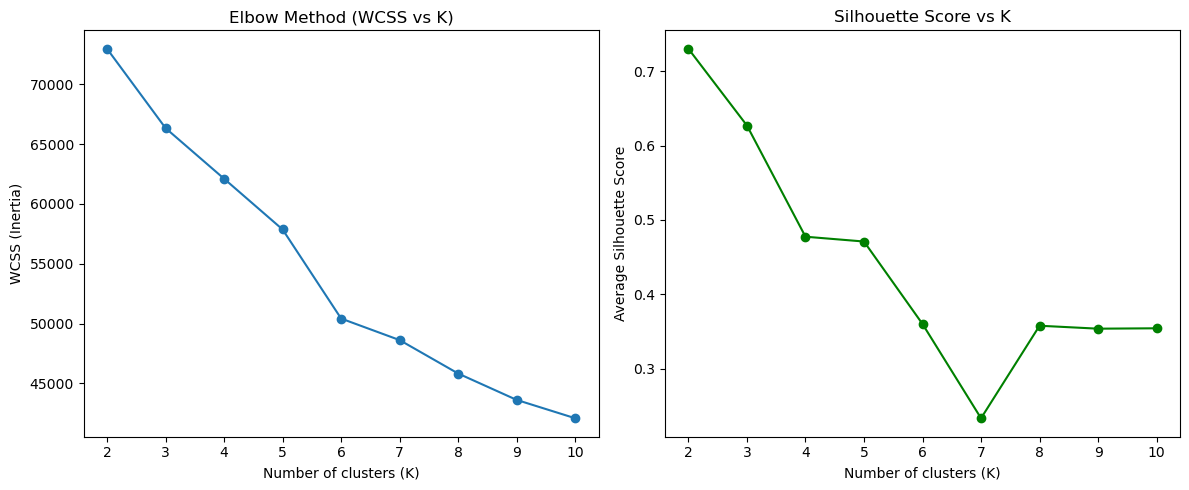

In [58]:
''' Elbow Rule to decide the number of clusters '''
torch.manual_seed(42)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(k_range, wcss, marker='o')
plt.title('Elbow Method (WCSS vs K)')
plt.xlabel('Number of clusters (K)')
plt.ylabel('WCSS (Inertia)')

# Step 5: Plot Silhouette Scores
plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, marker='o', color='green')
plt.title('Silhouette Score vs K')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Average Silhouette Score')

plt.tight_layout()
plt.show()

In [59]:
#Initialising KMeans
kmeans = KMeans(n_clusters=4, n_init=50, init='k-means++', random_state=42)
cluster_ids = kmeans.fit_predict(latent_np)
cluster_centers = torch.tensor(kmeans.cluster_centers_, dtype=torch.float32).to(device)

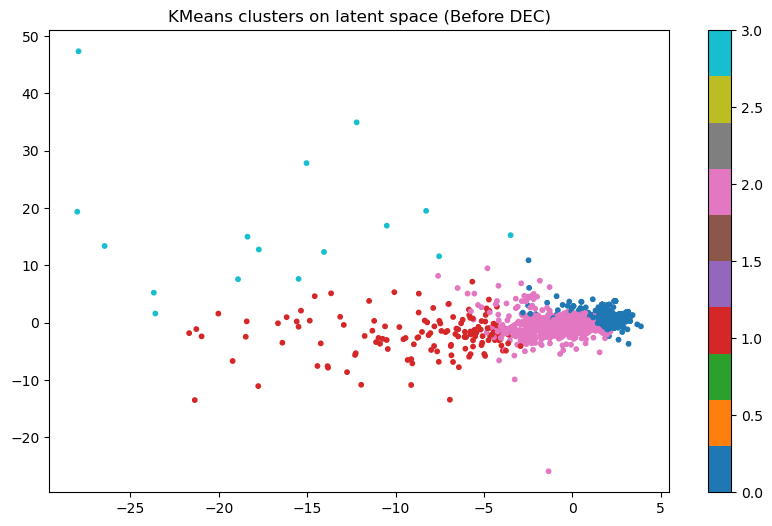

In [60]:
latent_2d = PCA(n_components=2).fit_transform(latent_np)
plt.figure(figsize=(10, 6))
plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=cluster_ids, cmap='tab10', s=10)
plt.title("KMeans clusters on latent space (Before DEC)")
plt.colorbar()
plt.show()

## Test it on User's Preferences 

In [62]:
X_df.columns

RangeIndex(start=0, stop=13, step=1)

In [63]:
df.columns

Index(['is_premium', 'subscription_status', 'company_size', 'total_sub',
       'is_unlimited', 'subscription_amount_in_dollars',
       'number_of_subscriptions', 'number_of_invitations', 'job_posted',
       'number_of_kits', 'number_of_recorded_interviews',
       'number_of_live_interviews', 'days_since_last_login'],
      dtype='object')

In [64]:
df['is_unlimited'].unique()

array([1, 0], dtype=int64)

In [65]:
backup_df = backup_df[['jobma_catcher_id',
                       'is_premium',
                         'subscription_status',
                         'company_size',
                        'total_sub',
                         'is_unlimited',
                         'subscription_amount_in_dollars',
                         'number_of_subscriptions',
                         'number_of_invitations',
                         'job_posted',
                         'number_of_kits',
                         'number_of_recorded_interviews',
                        'number_of_live_interviews',
                      'days_since_last_login']]

In [66]:
user_pref_good = {'is_premium':0,
             'subscription_status':0,
             'company_size':'101-500',
            'total_sub':1,
             'is_unlimited':0,
             'subscription_amount_in_dollars': 100.00,
             'number_of_subscriptions':1,
             'number_of_invitations':25,
             'job_posted':4,
             'number_of_kits':7,
             'number_of_recorded_interviews':8,
            'number_of_live_interviews':5,
            'days_since_last_login':'6-12 Months'
            }

In [67]:
compare_df = pd.read_csv('experiment_data1.csv')

In [68]:
compare_df.columns

Index(['jobma_catcher_id', 'is_premium', 'subscription_status', 'company_size',
       'total_sub', 'is_unlimited', 'subscription_amount_in_dollars',
       'number_of_subscriptions', 'number_of_invitations', 'job_posted',
       'number_of_kits', 'number_of_recorded_interviews',
       'number_of_live_interviews', 'days_since_last_login'],
      dtype='object')

In [69]:
compare_df['subscription_amount_in_dollars'].max()

118872599.99

In [70]:
# def recommend(user_input, model, latent_embeddings, compare_df, pipeline, top_k=5):
#     # Transform the user input using the pipeline
#     user_df = pd.DataFrame([user_input])
#     user_input_transformed = pipeline.transform(user_df)
#     user_input_tensor = torch.tensor(user_input_transformed, dtype=torch.float32)

#     model.eval()
#     with torch.no_grad():
#         # Get the user embedding
#         user_embedding, _ = model(user_input_tensor)
    
#     # Calculate cosine similarity with precomputed latent embeddings
#     similarities = F.cosine_similarity(user_embedding, torch.tensor(latent_embeddings), dim=1)
#     top_indices = similarities.topk(top_k).indices.cpu().numpy()

#     # Get the top K recommendations from the compare_df
#     recommended = compare_df.iloc[top_indices].copy()
#     recommended['similarity'] = similarities[top_indices].cpu().numpy()

#     return recommended

In [71]:
def recommend(user_input, model, latent_embeddings, compare_df, pipeline, top_k=5):
    # Transform the user input using the pipeline
    user_df = pd.DataFrame([user_input])
    user_input_transformed = pipeline.transform(user_df)
    user_input_tensor = torch.tensor(user_input_transformed, dtype=torch.float32)

    model.eval()
    with torch.no_grad():
        # Get the user embedding from the model
        user_embedding, _ = model(user_input_tensor)

        # Normalize the user embedding
        user_embedding = F.normalize(user_embedding, p=2, dim=1)

        # Convert latent embeddings to tensor and normalize
        latent_embeddings_tensor = torch.tensor(latent_embeddings, dtype=torch.float32)
        latent_embeddings_tensor = F.normalize(latent_embeddings_tensor, p=2, dim=1)

        # Calculate cosine similarity
        similarities = F.cosine_similarity(user_embedding, latent_embeddings_tensor, dim=1)

        # Get top K most similar indices
        top_indices = similarities.topk(top_k).indices.cpu().numpy()

        # Get the top K recommendations from the compare_df
        recommended = compare_df.iloc[top_indices].copy()
        recommended['similarity'] = similarities[top_indices].cpu().numpy()

    return recommended


In [72]:
# user_pref_good = {'is_premium':0,
#              'subscription_status':0,
#              'company_size':'101-500',
#             'total_sub':1,
#              'is_unlimited':0,
#              'subscription_amount_in_dollars': 100.00,
#              'number_of_subscriptions':1,
#              'number_of_invitations':25,
#              'job_posted':4,
#              'number_of_kits':7,
#              'number_of_recorded_interviews':8,
#             'number_of_live_interviews':5,
#             'days_since_last_login':'6-12 Months'
#             }

In [73]:
result = recommend(user_pref_good, model_1, latent_np, compare_df, pipeline, top_k=20)
result

,jobma_catcher_id,is_premium,subscription_status,company_size,total_sub,is_unlimited,subscription_amount_in_dollars,number_of_subscriptions,number_of_invitations,job_posted,number_of_kits,number_of_recorded_interviews,number_of_live_interviews,days_since_last_login,similarity
4424,10482,0,0,101-500,1,0,100.000000,1,25,4,7,8,5,6-12 Months,1.000000
4432,10499,0,0,1-25,1,0,250.000000,2,14,2,2,4,6,6-12 Months,0.972856
4403,10442,0,0,26-100,2,0,150.000000,1,70,5,13,43,2,6-12 Months,0.941672
4451,10523,0,0,1-25,1,0,645.312683,3,2,1,1,0,1,6-12 Months,0.934050
4128,10023,1,0,1-25,2,0,400.000000,4,98,7,26,12,26,6-12 Months,0.932649
4272,10247,0,0,26-100,1,0,0.000000,1,9,1,1,0,2,6-12 Months,0.930861
4422,10479,1,0,1-25,2,0,0.000000,1,9,2,3,2,1,6-12 Months,0.910184
4148,10058,0,0,1-25,2,0,350.000000,3,131,35,57,47,3,6-12 Months,0.898263
4118,9994,0,0,1-25,2,1,0.000000,1,241,22,4,44,29,6-12 Months,0.885783
4413,10462,0,0,1-25,2,0,250.000000,2,183,20,26,103,2,6-12 Months,0.881988


In [74]:
user_pref_test = {'is_premium':1,
             'subscription_status':1,
             'company_size':'1-25',
             'total_sub':2,
             'is_unlimited':1,
             'subscription_amount_in_dollars': 125.0,
             'number_of_subscriptions':1,
             'number_of_invitations':18,
             'job_posted':3,
             'number_of_kits':3,
             'number_of_recorded_interviews':3,
            'number_of_live_interviews':1,
            'days_since_last_login':'More than 1 Year'
            }

In [75]:
result1 = recommend(user_pref_test, model_1, latent_np, compare_df, pipeline, top_k=10)
result1

,jobma_catcher_id,is_premium,subscription_status,company_size,total_sub,is_unlimited,subscription_amount_in_dollars,number_of_subscriptions,number_of_invitations,job_posted,number_of_kits,number_of_recorded_interviews,number_of_live_interviews,days_since_last_login,similarity
188,3206,1,1,1-25,2,1,125.000000,1,18,3,3,3,1,More than 1 Year,1.000000
1320,4902,1,1,101-500,3,1,31.420861,4,28,13,2,11,2,More than 1 Year,0.972541
190,3214,1,1,1-25,1,1,100.000000,1,0,1,1,0,0,More than 1 Year,0.959364
195,3225,1,1,1-25,1,1,120.000000,1,1,1,1,1,0,More than 1 Year,0.935261
222,3280,1,1,26-100,3,1,80.000000,1,4,1,1,2,0,More than 1 Year,0.886060
203,3250,1,1,26-100,1,1,100.000000,1,0,1,1,0,0,More than 1 Year,0.883833
202,3249,1,1,26-100,2,1,10.000000,1,0,1,0,0,0,More than 1 Year,0.856120
123,3076,1,1,26-100,1,1,10.000000,1,4,2,2,1,0,More than 1 Year,0.854742
206,3258,1,1,26-100,1,1,100.000000,1,0,1,0,0,0,More than 1 Year,0.850680
1646,5510,1,1,26-100,1,1,9576.000000,2,0,2,1,0,0,More than 1 Year,0.829360


# Exporting

In [145]:
os.makedirs("Model/Model_Parameters", exist_ok=True)

In [147]:
''' Saving only State_dict (Parameters) '''

model_path = 'Model/Model_Parameters/ClientLoyaltyRecommender_model.pth'
torch.save(model_1.state_dict(), model_path)
print(f"Model Parameters saved at {model_path}")

Model Parameters saved at Model/Model_Parameters/ClientLoyaltyRecommender_model.pth


In [149]:
input_shape = X_df.shape[1]

model_with_loaded_params = AutoEncoder(input_shape)
model_with_loaded_params.load_state_dict(torch.load(model_path))
model_with_loaded_params.eval()

print("Model with only parameters loaded successfully")

Model with only parameters loaded successfully


In [155]:
# Save the preprocessing pipeline
with open("pipeline.pkl", "wb") as pipeline_file:
    pickle.dump(pipeline, pipeline_file)

In [183]:
# Saving the X_tensor
with open("X_tensor.pkl", "wb") as tensor_file:
    pickle.dump(X_tensor, tensor_file)